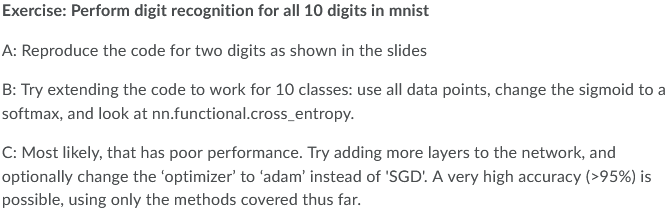

In [1]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch_directml
import sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import mnist_data

device = torch_directml.device(torch_directml.default_device()) 

In [2]:
# Check the number of available DirectML devices
num_devices = torch_directml.device_count()
print(f"Number of DirectML devices: {num_devices}")

Number of DirectML devices: 1


# A)

In [3]:
X, y = mnist_data()
# Just focus on 1 's and O' s:
keep=(y==0) | (y==1)
X=X[keep,:]
y=y[keep]

# Create test and training data :
Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)

# Transform into pytorch datasets;
trainDataset = torch.utils.data.TensorDataset(torch.tensor(Xtrain).float(),torch.tensor(ytrain).float())
testDataset = torch.utils.data.TensorDataset(torch.tensor(Xtest).float(),torch.tensor(ytest).float())

M,N = Xtrain.shape
print('Xtrain shape [M,N]:',[M,N])

Xtrain shape [M,N]: [700, 784]


In [4]:
# Making a neural network
class logRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputLayer=nn.Linear(784,1, bias=True)
    def forward(self,x):
        x = self.inputLayer(x)
        x = torch.sigmoid(x)
        return torch.squeeze(x)

In [5]:
# Quickly test network
testData = torch.rand((20,784))
testNet = logRegression()
testNet.forward(testData)

tensor([0.3640, 0.4464, 0.3745, 0.3925, 0.3472, 0.3593, 0.3281, 0.3628, 0.2848,
        0.3311, 0.3811, 0.3661, 0.3827, 0.3676, 0.3402, 0.4340, 0.3876, 0.3773,
        0.3835, 0.3507], grad_fn=<SqueezeBackward0>)

In [6]:
# Setup training of network
nEpochs = 10
learningRate = 0.001
batchSize = 64

# Move your dataset to DirectML if necessary
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True)

model = logRegression().to(device)  # Move model to DirectML device
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

loss_fn = nn.BCELoss()

accuracy = np.zeros(nEpochs)

for iEpoch in range(nEpochs):
    estimatedLabels = np.empty((0,))
    trueLabels = np.empty((0,))
    for xbatch, ybatch in trainDataLoader:
        # Move batch data to the DirectML device
        xbatch = xbatch.to(device)
        ybatch = ybatch.to(device)

        # Forward pass
        y_pred = model(xbatch)
        
        # Compute loss
        loss = loss_fn(y_pred, ybatch)

        # Backpropagation and optimization
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Convert predictions to binary (classification threshold 0.5)
        yhat = y_pred > 0.5

        # Collect predictions and true labels (move back to CPU for NumPy compatibility)
        estimatedLabels = np.append(estimatedLabels, yhat.cpu().numpy())
        trueLabels = np.append(trueLabels, ybatch.cpu().numpy())
    
    # Compute accuracy for the epoch
    accuracy[iEpoch] = np.mean(estimatedLabels == trueLabels)
    print(f"Epoch {iEpoch + 1}/{nEpochs}, Accuracy: {accuracy[iEpoch]:.4f}")


c:\repositories\DeepLearning\.venv\lib\site-packages\torch\nn\functional.py:3154: UserWarning: The operator 'aten::binary_cross_entropy' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch._C._nn.binary_cross_entropy(input, target, weight, reduction_enum)


Epoch 1/10, Accuracy: 0.9557
Epoch 2/10, Accuracy: 0.9943
Epoch 3/10, Accuracy: 0.9943
Epoch 4/10, Accuracy: 0.9943
Epoch 5/10, Accuracy: 0.9943
Epoch 6/10, Accuracy: 0.9943
Epoch 7/10, Accuracy: 0.9943
Epoch 8/10, Accuracy: 0.9943
Epoch 9/10, Accuracy: 0.9943
Epoch 10/10, Accuracy: 0.9943


(0.0, 1.0)

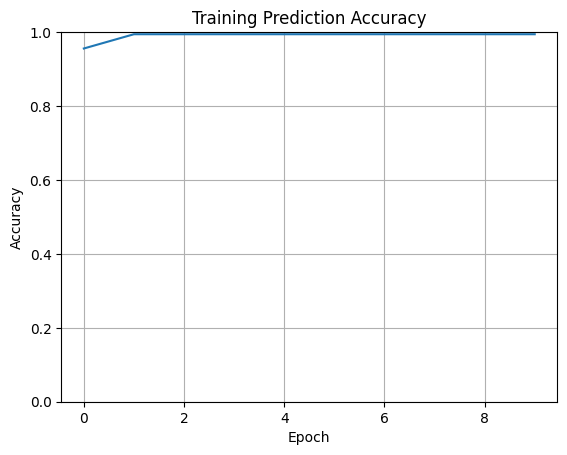

In [7]:
plt.plot(accuracy)
plt.title('Training Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0,1])

# B)

In [12]:
# Load data again
X,y = mnist_data()
# Create test and training data :
Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)

# Transform into pytorch datasets;
trainDataset = torch.utils.data.TensorDataset(torch.tensor(Xtrain).float(),torch.tensor(ytrain).float())
testDataset = torch.utils.data.TensorDataset(torch.tensor(Xtest).float(),torch.tensor(ytest).float())

M,N = Xtrain.shape
print('Xtrain shape [M,N]:',[M,N])

Xtrain shape [M,N]: [3500, 784]


In [13]:
# Making a neural network
class logRegression_10(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputLayer=nn.Linear(784,10, bias=True)
    def forward(self,x):
        x = self.inputLayer(x)
        m = nn.Softmax(dim=0)
        x = m(x)
        return torch.squeeze(x)

In [14]:
# Setup training of network
nEpochs = 100
learningRate = 0.001
batchSize = 64

# Move your dataset to DirectML if necessary
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True)

model = logRegression_10().to(device)  # Move model to DirectML device
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

accuracy = np.zeros(nEpochs)

for iEpoch in range(nEpochs):
    estimatedLabels = np.empty((0,))
    trueLabels = np.empty((0,))
    for xbatch, ybatch in trainDataLoader:
        # Move batch data to the DirectML device
        xbatch = xbatch.to(device)
        ybatch = ybatch.to(device)

        # Long
        ybatch = ybatch.long()

        # Forward pass
        y_pred = model(xbatch)
        
        # cross entropy loss function between expected and model output
        # DirectML gives weird behaviour - sent to cpu instead...
        loss = nn.functional.cross_entropy(y_pred,ybatch)

        # Backpropagation and optimization
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect predictions and true labels (move back to CPU for NumPy compatibility)
        [max_v, yhat] = torch.max(y_pred,dim=1)
        estimatedLabels = np.append(estimatedLabels, torch.Tensor.cpu(yhat))
        trueLabels = np.append(trueLabels, torch.Tensor.cpu(ybatch))
    
    # Compute accuracy for the epoch
    accuracy[iEpoch] = np.mean(estimatedLabels == trueLabels)
    print(f"Epoch {iEpoch + 1}/{nEpochs}, Accuracy: {accuracy[iEpoch]:.4f}")

Epoch 1/100, Accuracy: 0.1086
Epoch 2/100, Accuracy: 0.1451
Epoch 3/100, Accuracy: 0.1874
Epoch 4/100, Accuracy: 0.2231
Epoch 5/100, Accuracy: 0.2383
Epoch 6/100, Accuracy: 0.2809
Epoch 7/100, Accuracy: 0.2963
Epoch 8/100, Accuracy: 0.3120
Epoch 9/100, Accuracy: 0.3154
Epoch 10/100, Accuracy: 0.3263
Epoch 11/100, Accuracy: 0.3420
Epoch 12/100, Accuracy: 0.3666
Epoch 13/100, Accuracy: 0.3994
Epoch 14/100, Accuracy: 0.4140
Epoch 15/100, Accuracy: 0.4260
Epoch 16/100, Accuracy: 0.4400
Epoch 17/100, Accuracy: 0.4386
Epoch 18/100, Accuracy: 0.4454
Epoch 19/100, Accuracy: 0.4520
Epoch 20/100, Accuracy: 0.4571
Epoch 21/100, Accuracy: 0.4569
Epoch 22/100, Accuracy: 0.4514
Epoch 23/100, Accuracy: 0.4534
Epoch 24/100, Accuracy: 0.4594
Epoch 25/100, Accuracy: 0.4677
Epoch 26/100, Accuracy: 0.4806
Epoch 27/100, Accuracy: 0.4791
Epoch 28/100, Accuracy: 0.4831
Epoch 29/100, Accuracy: 0.4729
Epoch 30/100, Accuracy: 0.4903
Epoch 31/100, Accuracy: 0.4869
Epoch 32/100, Accuracy: 0.5037
Epoch 33/100, Acc

(0.0, 1.0)

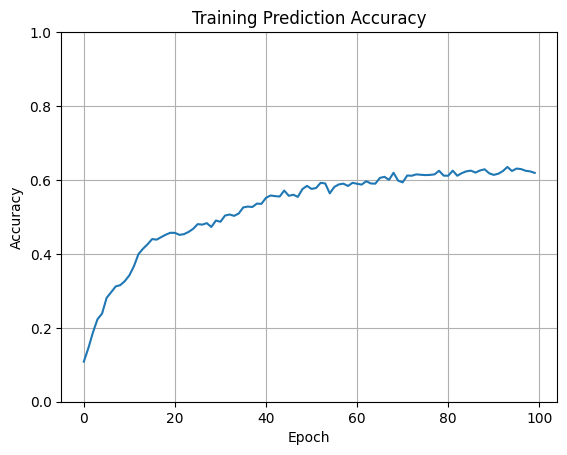

In [15]:
plt.plot(accuracy)
plt.title('Training Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0,1])

# C)

In [104]:
# Load data again
X,y = mnist_data()
# Create test and training data :
Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)

# Convert data to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain).float()
Xtest_tensor = torch.tensor(Xtest).float()
ytrain_tensor = torch.tensor(ytrain).float()
ytest_tensor = torch.tensor(ytest).float()

# Move tensors to GPU
Xtrain_tensor = Xtrain_tensor.to(device)
Xtest_tensor = Xtest_tensor.to(device)
ytrain_tensor = ytrain_tensor.to(device)
ytest_tensor = ytest_tensor.to(device)

# Transform into pytorch datasets;
trainDataset = torch.utils.data.TensorDataset(Xtrain_tensor, ytrain_tensor)
testDataset = torch.utils.data.TensorDataset(Xtest_tensor, ytest_tensor)

M,N = Xtrain.shape
print('Xtrain shape [M,N]:',[M,N])

Xtrain shape [M,N]: [3500, 784]


In [105]:
# Making a neural network
class logRegression_10_net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 100, bias=True)
        self.linear2 = nn.Linear(100, 50, bias=True)
        self.linear3 = nn.Linear(50, 10, bias=True)
        self.softmax = nn.Softmax(dim=0)
        self.ReLu = nn.ReLU()
    def forward(self,x):
        x = self.linear1(x)
        x = self.ReLu(x)
        x = self.linear2(x)
        x = self.ReLu(x)
        x = self.linear3(x)
        m = nn.Softmax(dim=0)
        x = m(x)
        return torch.squeeze(x)

In [106]:
# Setup training of network
nEpochs = 200
learningRate = 0.00008
batchSize = 64

# Set a seed
random_seed = 1
torch.manual_seed(random_seed)

# Move your dataset to DirectML if necessary
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True, pin_memory=True)

model = logRegression_10_net2().to(device)  # Move model to DirectML device
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

accuracy = torch.zeros(nEpochs, device=device)

for iEpoch in range(nEpochs):
    estimatedLabels = torch.empty(0, device=device)
    trueLabels = torch.empty(0, device=device) 
    for xbatch, ybatch in trainDataLoader:
        # Move batch data to the DirectML device
        xbatch = xbatch.to(device)
        ybatch = ybatch.to(device).long()

        # Forward pass
        y_pred = model(xbatch)
        
        # cross entropy loss function between expected and model output
        # DirectML gives weird behaviour - sent to cpu instead...
        loss = nn.functional.cross_entropy(y_pred, ybatch)
        # Backpropagation and optimization
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect predictions and true labels (move back to CPU for NumPy compatibility)
        [max_v, yhat] = torch.max(y_pred,dim=1)
        estimatedLabels = torch.cat((estimatedLabels, yhat))
        trueLabels = torch.cat((trueLabels, ybatch))
    
    # Compute accuracy for the epoch
    accuracy[iEpoch] = (estimatedLabels == trueLabels).float().mean()
    print(f"Epoch {iEpoch + 1}/{nEpochs}, Accuracy: {accuracy[iEpoch]:.4f}")

Epoch 1/200, Accuracy: 0.1460
Epoch 2/200, Accuracy: 0.2783
Epoch 3/200, Accuracy: 0.4051
Epoch 4/200, Accuracy: 0.4377
Epoch 5/200, Accuracy: 0.4820
Epoch 6/200, Accuracy: 0.5220
Epoch 7/200, Accuracy: 0.5863
Epoch 8/200, Accuracy: 0.6211
Epoch 9/200, Accuracy: 0.6489
Epoch 10/200, Accuracy: 0.6651
Epoch 11/200, Accuracy: 0.6617
Epoch 12/200, Accuracy: 0.6889
Epoch 13/200, Accuracy: 0.6891
Epoch 14/200, Accuracy: 0.7049
Epoch 15/200, Accuracy: 0.7040
Epoch 16/200, Accuracy: 0.7183
Epoch 17/200, Accuracy: 0.7403
Epoch 18/200, Accuracy: 0.7443
Epoch 19/200, Accuracy: 0.7303
Epoch 20/200, Accuracy: 0.7506
Epoch 21/200, Accuracy: 0.7426
Epoch 22/200, Accuracy: 0.7449
Epoch 23/200, Accuracy: 0.7614
Epoch 24/200, Accuracy: 0.7654
Epoch 25/200, Accuracy: 0.7697
Epoch 26/200, Accuracy: 0.7614
Epoch 27/200, Accuracy: 0.7846
Epoch 28/200, Accuracy: 0.7934
Epoch 29/200, Accuracy: 0.7871
Epoch 30/200, Accuracy: 0.7897
Epoch 31/200, Accuracy: 0.7854
Epoch 32/200, Accuracy: 0.7894
Epoch 33/200, Acc

In [107]:
print(y_pred.device, ybatch.device, loss.device)

privateuseone:0 privateuseone:0 privateuseone:0


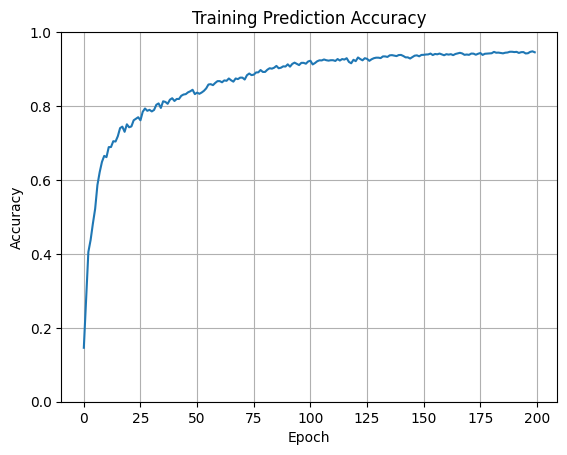

Max training accuracy:  0.948


In [108]:
# Move accuracy tensor to CPU and convert to NumPy array
accuracy_cpu = accuracy.cpu().numpy()

# Plot training accuracy
plt.plot(accuracy_cpu)
plt.title('Training Prediction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim([0, 1])
plt.show()  # Display the plot

# Print maximum training accuracy
print('Max training accuracy: ', np.max(accuracy_cpu))

# TEST ON CPU

In [97]:
# Set device to CPU
device = torch.device('cpu')

# Load data again
X,y = mnist_data()
# Create test and training data :
Xtrain,Xtest,ytrain,ytest=sklearn.model_selection.train_test_split(X,y,test_size=0.3,shuffle=True)

# Convert data to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain).float()
Xtest_tensor = torch.tensor(Xtest).float()
ytrain_tensor = torch.tensor(ytrain).float()
ytest_tensor = torch.tensor(ytest).float()

# Move tensors to GPU
Xtrain_tensor = Xtrain_tensor.to(device)
Xtest_tensor = Xtest_tensor.to(device)
ytrain_tensor = ytrain_tensor.to(device)
ytest_tensor = ytest_tensor.to(device)

# Transform into pytorch datasets;
trainDataset = torch.utils.data.TensorDataset(Xtrain_tensor, ytrain_tensor)
testDataset = torch.utils.data.TensorDataset(Xtest_tensor, ytest_tensor)

M,N = Xtrain.shape
print('Xtrain shape [M,N]:',[M,N])

Xtrain shape [M,N]: [3500, 784]


In [98]:
# Making a neural network
class logRegression_10_net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 100, bias=True)
        self.linear2 = nn.Linear(100, 50, bias=True)
        self.linear3 = nn.Linear(50, 10, bias=True)
        self.softmax = nn.Softmax(dim=0)
        self.ReLu = nn.ReLU()
    def forward(self,x):
        x = self.linear1(x)
        x = self.ReLu(x)
        x = self.linear2(x)
        x = self.ReLu(x)
        x = self.linear3(x)
        m = nn.Softmax(dim=0)
        x = m(x)
        return torch.squeeze(x)

In [99]:
# Setup training of network
nEpochs = 200
learningRate = 0.00008
batchSize = 64

# Set a seed
random_seed = 1
torch.manual_seed(random_seed)

# Move your dataset to DirectML if necessary
trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True)

model = logRegression_10_net2().to(device)  # Move model to DirectML device
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

accuracy = torch.zeros(nEpochs, device=device)

for iEpoch in range(nEpochs):
    estimatedLabels = torch.empty(0, device=device)
    trueLabels = torch.empty(0, device=device) 
    for xbatch, ybatch in trainDataLoader:
        # Move batch data to the DirectML device
        xbatch = xbatch.to(device)
        ybatch = ybatch.to(device).long()

        # Forward pass
        y_pred = model(xbatch)
        
        # cross entropy loss function between expected and model output
        # DirectML gives weird behaviour - sent to cpu instead...
        loss = nn.functional.cross_entropy(y_pred, ybatch)
        # Backpropagation and optimization
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect predictions and true labels (move back to CPU for NumPy compatibility)
        [max_v, yhat] = torch.max(y_pred,dim=1)
        estimatedLabels = torch.cat((estimatedLabels, yhat))
        trueLabels = torch.cat((trueLabels, ybatch))
    
    # Compute accuracy for the epoch
    accuracy[iEpoch] = (estimatedLabels == trueLabels).float().mean()
    print(f"Epoch {iEpoch + 1}/{nEpochs}, Accuracy: {accuracy[iEpoch]:.4f}")

Epoch 1/200, Accuracy: 0.1591
Epoch 2/200, Accuracy: 0.2974
Epoch 3/200, Accuracy: 0.3840
Epoch 4/200, Accuracy: 0.4714
Epoch 5/200, Accuracy: 0.5131
Epoch 6/200, Accuracy: 0.5634
Epoch 7/200, Accuracy: 0.5831
Epoch 8/200, Accuracy: 0.5897
Epoch 9/200, Accuracy: 0.6077
Epoch 10/200, Accuracy: 0.6131
Epoch 11/200, Accuracy: 0.6600
Epoch 12/200, Accuracy: 0.6537
Epoch 13/200, Accuracy: 0.6837
Epoch 14/200, Accuracy: 0.6911
Epoch 15/200, Accuracy: 0.6940
Epoch 16/200, Accuracy: 0.7060
Epoch 17/200, Accuracy: 0.7140
Epoch 18/200, Accuracy: 0.7114
Epoch 19/200, Accuracy: 0.7074
Epoch 20/200, Accuracy: 0.7203
Epoch 21/200, Accuracy: 0.7163
Epoch 22/200, Accuracy: 0.7240
Epoch 23/200, Accuracy: 0.7197
Epoch 24/200, Accuracy: 0.7311
Epoch 25/200, Accuracy: 0.7303
Epoch 26/200, Accuracy: 0.7483
Epoch 27/200, Accuracy: 0.7537
Epoch 28/200, Accuracy: 0.7549
Epoch 29/200, Accuracy: 0.7540
Epoch 30/200, Accuracy: 0.7546
Epoch 31/200, Accuracy: 0.7506
Epoch 32/200, Accuracy: 0.7631
Epoch 33/200, Acc